In [1]:
import os
import time
import random
import sys  
import matplotlib.pyplot as plt
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
import pandas as pd
import numpy as np
import torch.nn as nn
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from collections import defaultdict

In [2]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.activations_and_gradients import ActivationsAndGradients
from pytorch_grad_cam.utils.find_layers import replace_all_layer_type_recursive
from pytorch_grad_cam.base_cam import BaseCAM

from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import deprocess_image

In [3]:
ROOT_DIR = os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), "../"))
if ROOT_DIR not in sys.path:
    sys.path.insert(0, ROOT_DIR)
from src.dataset.datamodule_triplet_kfold import DocumentDataModule
from torch.utils.data import DataLoader

In [4]:
from hydra import initialize_config_dir, compose


with initialize_config_dir(config_dir=f"{ROOT_DIR}/configs"):
    cfg = compose(config_name="config")

# ❌ 아래 줄은 쓰면 안 됨 (cfg.hydra가 없음)
# HydraConfig.instance().set_config(cfg)

# cfg는 이제 자유롭게 사용 가능
print(cfg.model.name)


efficientnetb5_triplet


In [5]:
from src.model.efficientNetB5_triplet import EfficientNetB5TripletClassifier
model_list = []
dm_list = []
model_name = cfg.model.name
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for fold in range(5):
  model_path = os.path.join(ROOT_DIR, 'artifacts', model_name, f'{model_name}_fold{fold}-v1.ckpt')
  model = EfficientNetB5TripletClassifier.load_from_checkpoint(model_path)
  model.to(device)
  model.eval()
  model_list.append(model)
  dm = DocumentDataModule(fold=fold)
  dm.setup("analyze")
  dm_list.append(dm)



In [6]:
from script.analyze.gradcam import analyze_gradcam

correct_dict_list = []
incorrect_dict_list = []
for fold, (model, dm) in enumerate(zip(model_list, dm_list)):
  correct_dict, incorrect_dict = analyze_gradcam(model, dm, fold)
  correct_dict_list.append(correct_dict)
  incorrect_dict_list.append(incorrect_dict)


100%|██████████| 20/20 [00:20<00:00,  1.00s/it]


In [7]:
display(correct_dict_list[0][0])

[tensor([[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          ...,
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489]],
 
         [[2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          ...,
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286]],
 
         [[2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400, 2.6400,  ...,

In [26]:
def visualize_gradcam(model, image_tensors_dict, title='correct', device="cuda", target_layer=None):

    num_classes = len(image_tensors_dict)
    valid_classes = [label for label, tensors in image_tensors_dict.items() if len(tensors) > 0]
    n_rows = len(valid_classes)
    n_cols = 5  # 최대 5개

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3))
    if n_rows == 1:
        axes = [axes]  # 1행일 경우 axes를 리스트로 변환

    for row_idx, label in enumerate(valid_classes):
        image_tensors = image_tensors_dict[label][:5]  # 최대 5개
        targets = [ClassifierOutputTarget(label)]

        for col_idx, image_tensor in enumerate(image_tensors):
            # Grad-CAM 준비
            cam = GradCAM(model=model, target_layers=[target_layer])
            input_tensor = image_tensor.unsqueeze(0).to(device)

            # Normalize for visualization
            img_np = image_tensor.permute(1, 2, 0).cpu().numpy()
            img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

            grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]
            visualization = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)

            ax = axes[row_idx][col_idx] if n_rows > 1 else axes[0][col_idx]
            ax.imshow(visualization)
            ax.axis('off')
            ax.set_title(f'{label} {title} #{col_idx+1}')

        # 나머지 빈 칸 비우기
        for col_idx in range(len(image_tensors), n_cols):
            ax = axes[row_idx][col_idx] if n_rows > 1 else axes[0][col_idx]
            ax.axis('off')

    plt.tight_layout()
    plt.show()

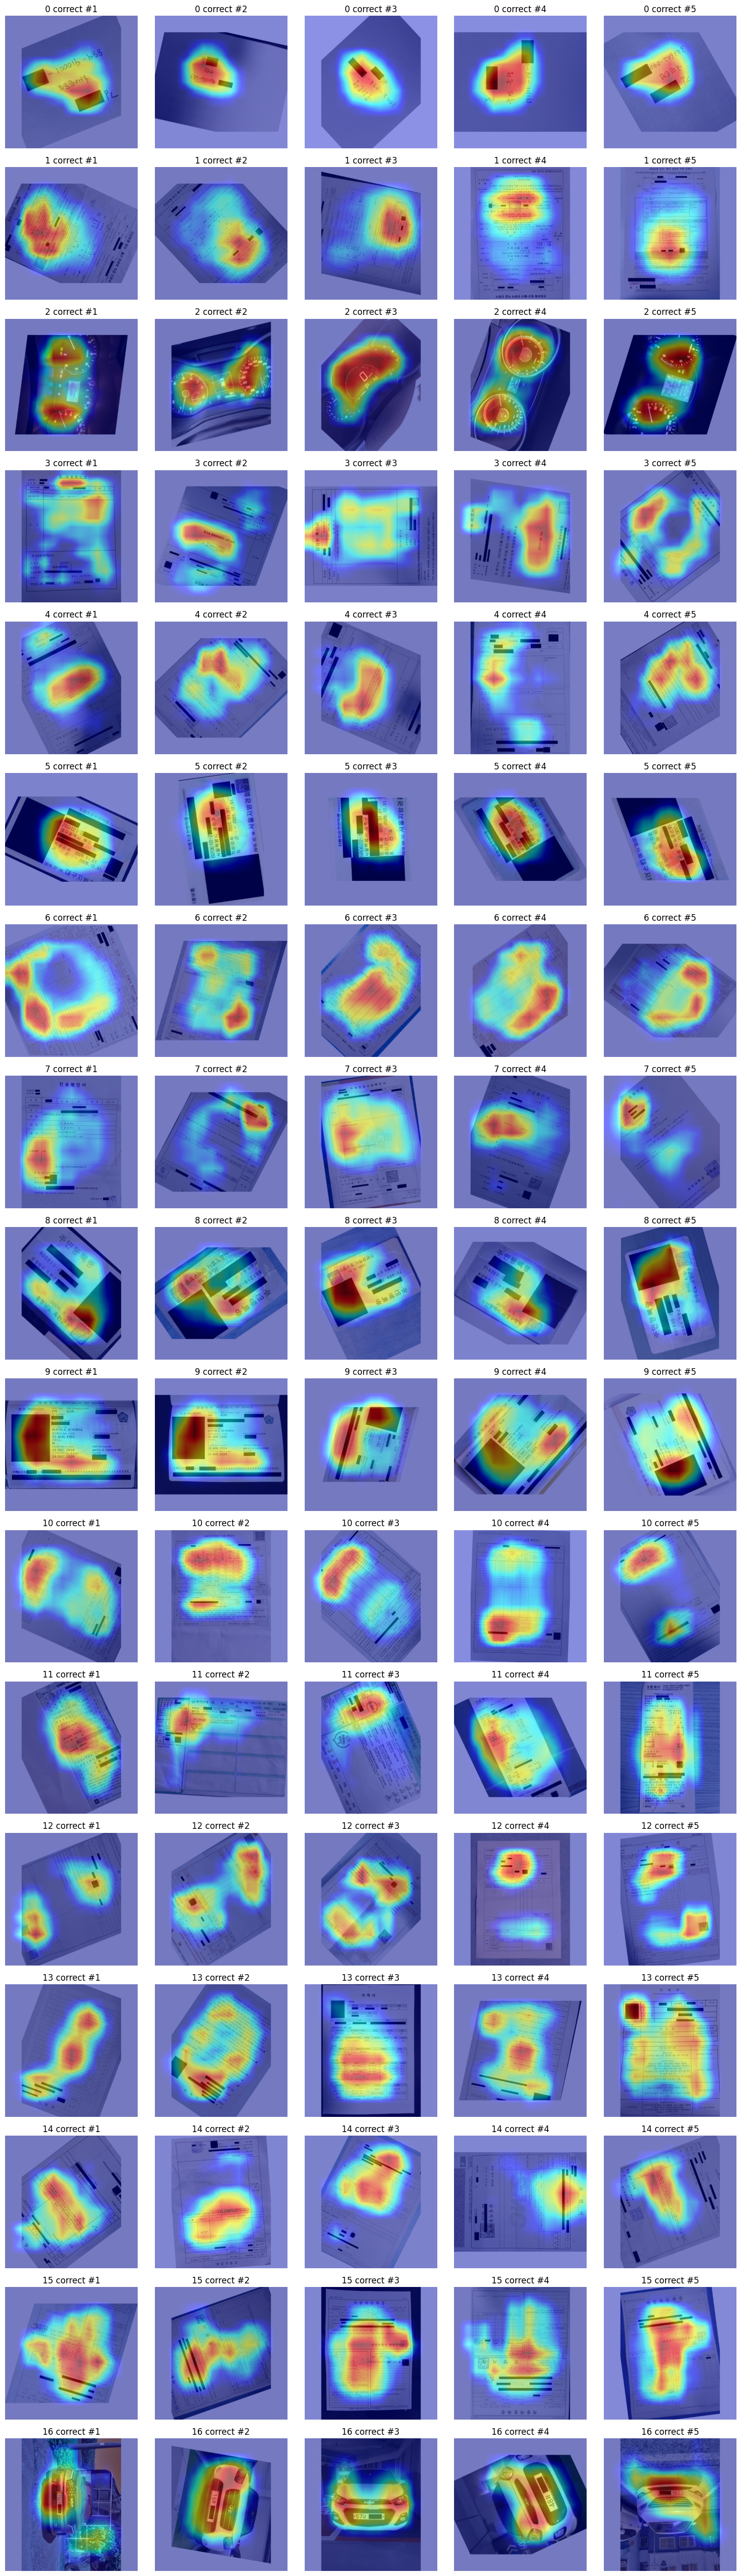

In [29]:
fold = 0
class_idx = 0
model = model_list[fold].model
img_tensors_dict = correct_dict_list[fold]
target_layer = model.conv_head
title = "correct"

visualize_gradcam(model, img_tensors_dict, target_layer=target_layer, title=title)

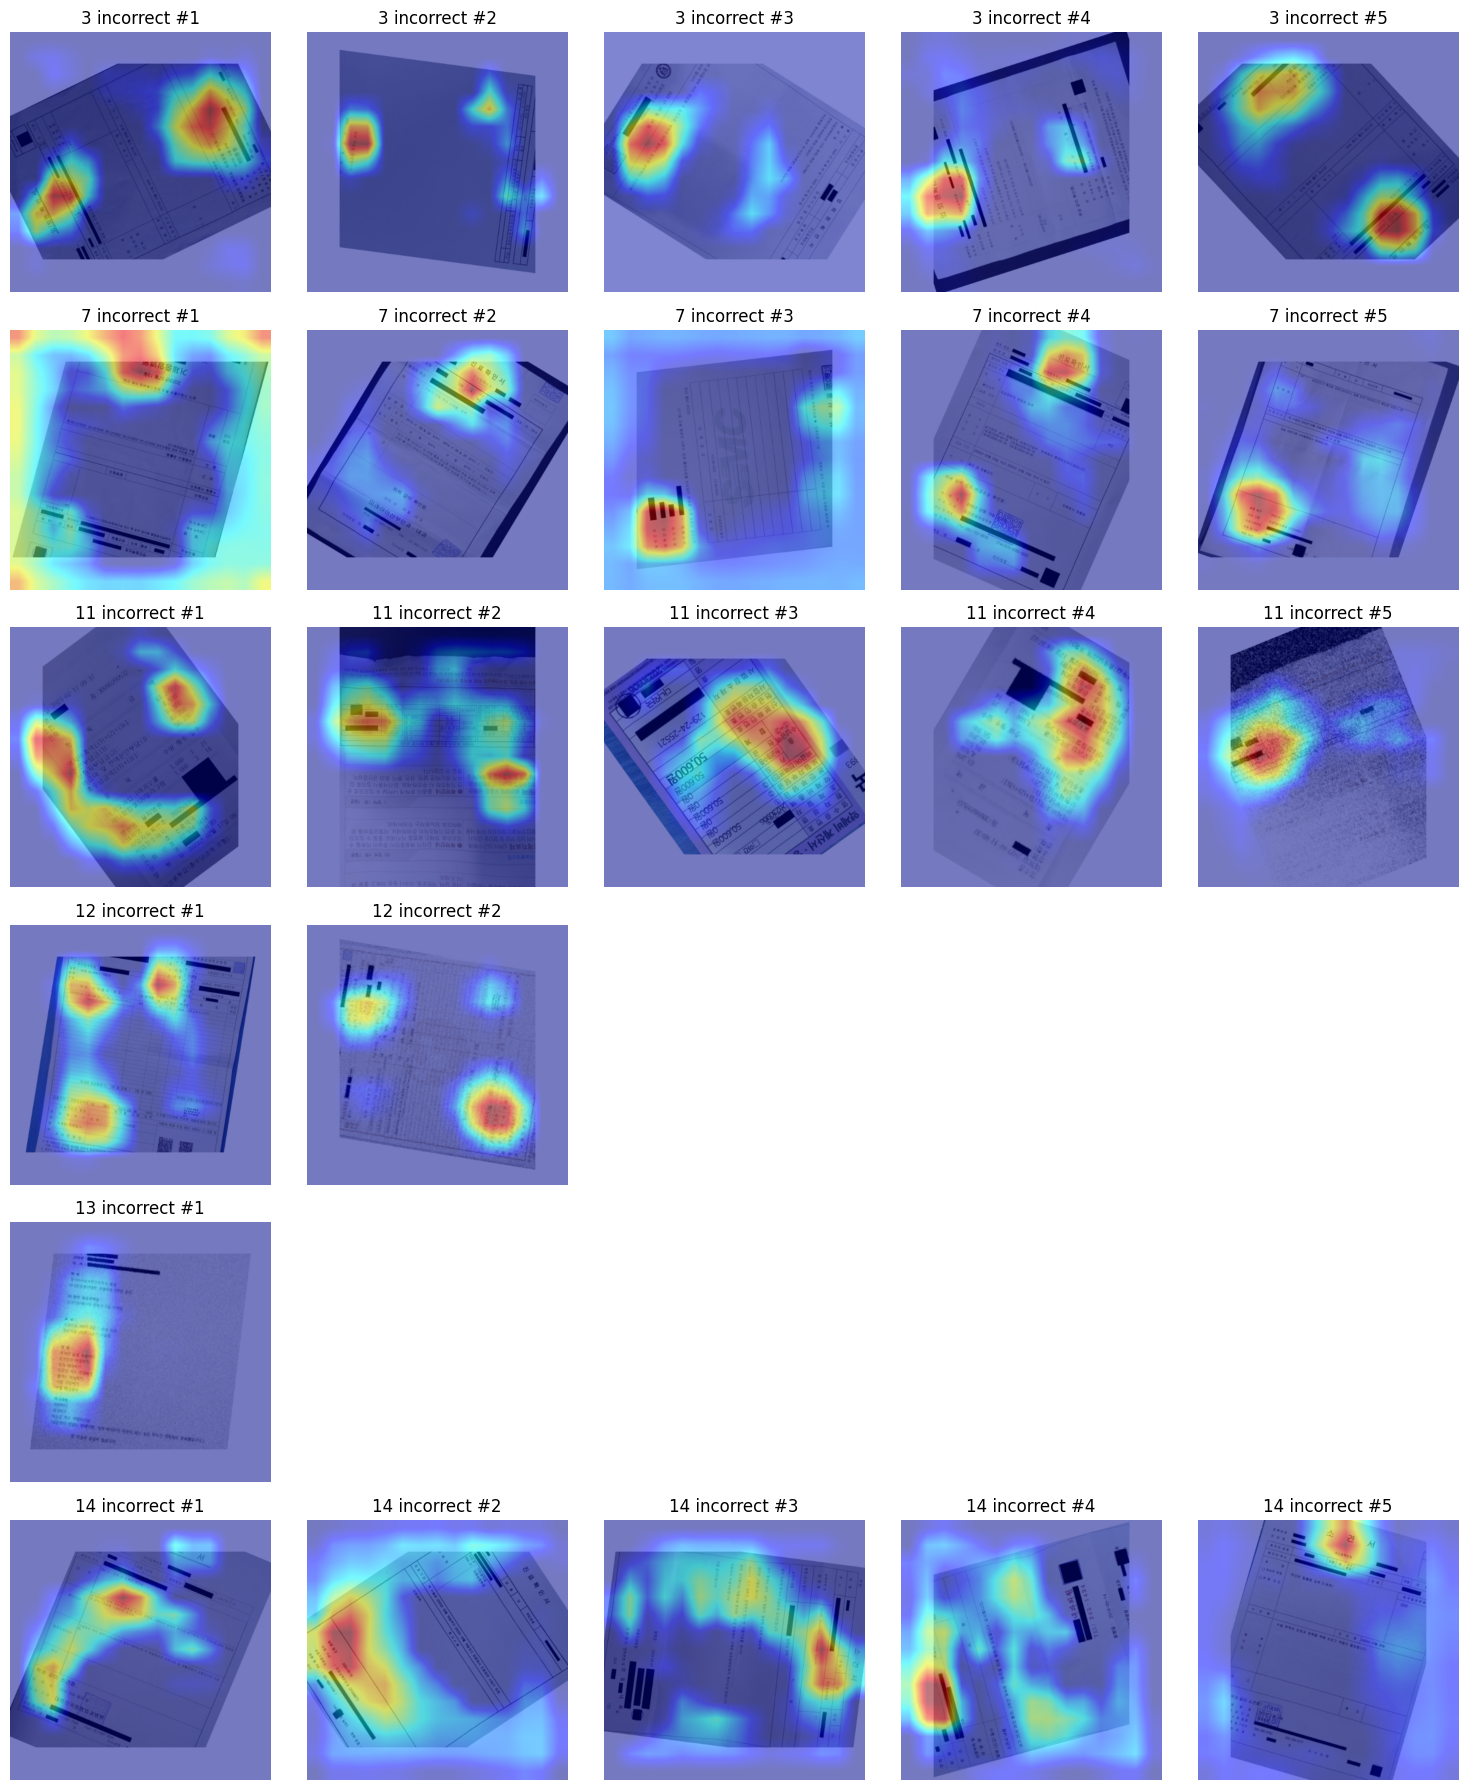

In [31]:
fold = 1
class_idx = 0
model = model_list[fold].model
img_tensors_dict = incorrect_dict_list[fold]
target_layer = model.conv_head
title = "incorrect"

visualize_gradcam(model, img_tensors_dict, target_layer=target_layer, title=title)